In [ ]:
from pathlib import Path # this one Folder handle 

base = Path("data/raw")
(base / "kedarsai").mkdir(parents=True, exist_ok=True)
(base / "saisirishan").mkdir(parents=True, exist_ok=True)

print("✅ Folders ready inside your project path!")
print(base.resolve())


✅ Folders ready inside your project path!
D:\vscode\data\raw


In [ ]:
# unzip datasets --
import zipfile, sys, pathlib
from pathlib import Path

base = Path("data/raw")
ked = base/"kedarsai"
sai = base/"saisirishan"

def unzip_if_exists(zip_path):
    if zip_path.exists():
        print("Unzipping:", zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(zip_path.parent)
        print("Done:", zip_path)
    else:
        print("Not found:", zip_path)

# update names:
zip1 = ked/"archive.zip"
zip2 = sai/"archive (1).zip"

unzip_if_exists(zip1)
unzip_if_exists(zip2)

# list all the folders:
print("\nAfter unzip — top folders:")
for p in [ked, sai]:
    for item in p.parent.iterdir():
        if item.is_dir():
            print("-", item)


Unzipping: data\raw\kedarsai\archive.zip
Done: data\raw\kedarsai\archive.zip
Unzipping: data\raw\saisirishan\archive (1).zip
Done: data\raw\saisirishan\archive (1).zip

After unzip — top folders:
- data\raw\indian_lp
- data\raw\kedarsai
- data\raw\saisirishan
- data\raw\indian_lp
- data\raw\kedarsai
- data\raw\saisirishan


In [ ]:
# Ctotal image count after merge:
import os
from pathlib import Path

def count_images(folder):
    p = Path(folder)
    imgs = list(p.rglob("*.jpg")) + list(p.rglob("*.jpeg")) + list(p.rglob("*.png"))
    return len(imgs)

print("KedarSai images:", count_images("data/raw/kedarsai"))
print("SaiSirisha images:", count_images("data/raw/saisirishan"))
print("Total (before merge):", count_images("data/raw/kedarsai") + count_images("data/raw/saisirishan"))


KedarSai images: 2083
SaiSirisha images: 1698
Total (before merge): 3781


In [ ]:
# merge datasets and copy image and files:
import shutil, uuid
from pathlib import Path

src_folders = [Path("data/raw/kedarsai"), Path("data/raw/saisirishan")]
dst = Path("data/raw/indian_lp")
dst.mkdir(parents=True, exist_ok=True)
dst_labels = dst/"labels"
dst_labels.mkdir(parents=True, exist_ok=True)

label_exts = [".txt", ".xml", ".json"] # YOLO / Pascal VOC / JSON labels ellam support ku

copied = 0
skipped = 0
collision = 0

def safe_copy(src_path, dst_dir):
    dst_path = dst_dir / src_path.name
    if not dst_path.exists():
        shutil.copy(src_path, dst_path)
        return dst_path.name
    else:
        # filename same ah irntha rename panna:
        new_name = f"{src_path.stem}_{uuid.uuid4().hex[:8]}{src_path.suffix}"
        new_dst = dst_dir / new_name
        shutil.copy(src_path, new_dst)
        return new_name

for sf in src_folders:
    if not sf.exists():
        print("Source folder missing:", sf)
        continue
    for img in sf.rglob("*"):
        if img.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        new_name = safe_copy(img, dst)
        copied += 1
        # try to copy label files with same stem
        for le in label_exts:
            lab_src = img.with_suffix(le)
            # also check common label folders like labels/ or annotations/
            if not lab_src.exists():
                alt = sf / "labels" / (img.stem + le)
                if alt.exists():
                    lab_src = alt
            if lab_src.exists():
                # copy to dst/labels with same new_name stem
                new_stem = Path(new_name).stem
                dst_lab = dst_labels / (new_stem + le)
                shutil.copy(lab_src, dst_lab)
        # end label copy
print(f"Copied images: {copied}. Labels placed into {dst_labels}")


Copied images: 3781. Labels placed into data\raw\indian_lp\labels


In [1]:
#merged images oda count:
from pathlib import Path
print("Merged images:", len(list(Path("data/raw/indian_lp").glob("*.jpg"))))


Merged images: 6261


Image: 00000000.jpg


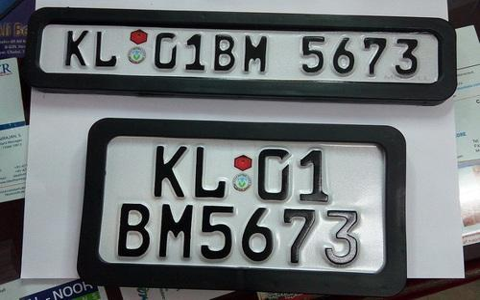

Label (.txt) content:
0 0.507305 0.174466 0.852273 0.242771
0 0.509334 0.678400 0.624188 0.502707
------
Image: 00000000_1af6c6ff.jpg


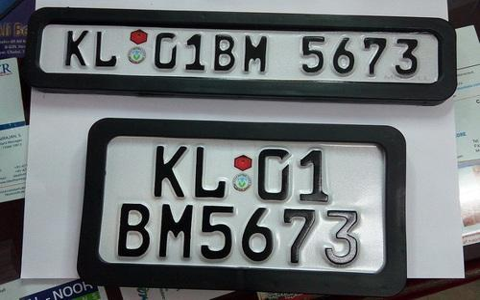

Label (.txt) content:
0 0.507305 0.174466 0.852273 0.242771
0 0.509334 0.678400 0.624188 0.502707
------
Image: 00000000_c7fd5d2a.jpg


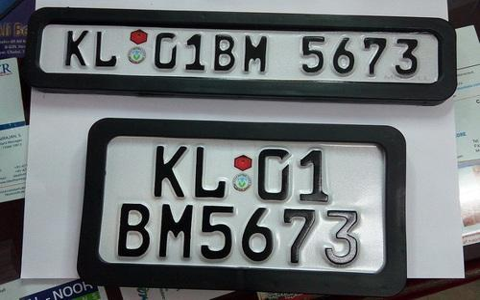

Label (.txt) content:
0 0.507305 0.174466 0.852273 0.242771
0 0.509334 0.678400 0.624188 0.502707
------
Image: 00000000_dbecc08b.jpg


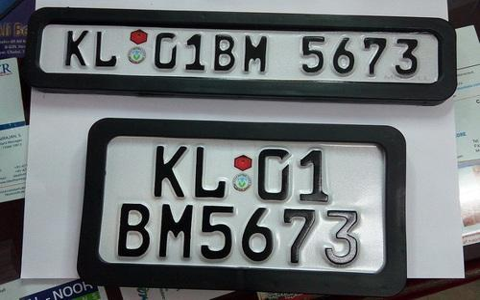

Label (.txt) content:
0 0.507305 0.174466 0.852273 0.242771
0 0.509334 0.678400 0.624188 0.502707
------
Image: 00000000_f1cdec98.jpg


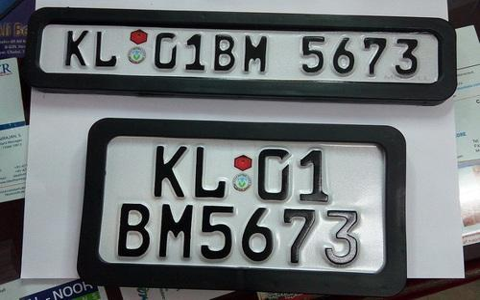

Label (.txt) content:
0 0.507305 0.174466 0.852273 0.242771
0 0.509334 0.678400 0.624188 0.502707
------
Image: 00000001.jpg


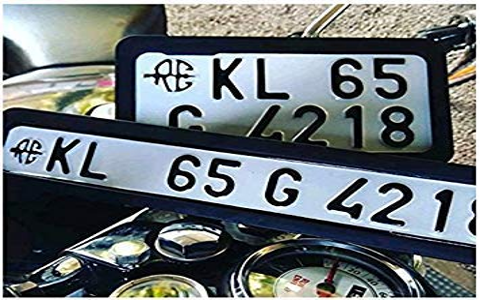

Label (.txt) content:
0 0.601563 0.332953 0.661153 0.364880
0 0.515012 0.620867 0.969976 0.434436
------


In [ ]:
# Images + Labels crt ah nu print panna:
from PIL import Image, ImageOps, Image
from IPython.display import display
from pathlib import Path

imgs = list(Path("data/raw/indian_lp").glob("*.jpg"))[:6]
for img in imgs:
    print("Image:", img.name)
    display(Image.open(img).resize((480,300)))
    lab = Path("data/raw/indian_lp/labels") / (img.stem + ".txt")
    if lab.exists():
        print("Label (.txt) content:")
        print(lab.read_text()[:500])
    else:
        print("No .txt label found for this image")
    print("------")


In [ ]:
# --- CREATE data.yaml for training panna dataset path, class names, structure yolo undertandku
from pathlib import Path

proc = Path("data/processed/yolo")
train_dir = (proc / "images" / "train").resolve()
val_dir   = (proc / "images" / "val").resolve()

out_yaml = proc / "data.yaml"

content = f"""
train: {train_dir.as_posix()}
val: {val_dir.as_posix()}
nc: 1
names: ['plate']
"""

out_yaml.write_text(content.strip())
print("data.yaml created at:", out_yaml)
print(out_yaml.read_text())


In [ ]:
# Train_tha model_YOLO
from ultralytics import YOLO
import warnings
warnings.filterwarnings("ignore")

model = YOLO('yolov8n.pt')

model.train(
    data='data/processed/yolo/data.yaml',
    epochs=3,
    imgsz=640,
    batch=2,        # keep small for CPU
    name='alpr_cpu_test',
    device='cpu'    # force CPU
)
print("✅ CPU training test finished. Check runs/detect/alpr_cpu_test/")


Starting a short CPU training test (epochs=3, small batch). This is slow but checks dataset.
New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.227  Python-3.10.11 torch-2.9.0+cpu CPU (AMD Ryzen 5 7520U with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/processed/yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, mo

In [ ]:
#save the model:
from ultralytics import YOLO

model = YOLO(r"D:\vscode\runs\detect\alpr_cpu_test7\weights\best.pt")


In [ ]:
#Test one image using our model:
from ultralytics import YOLO
import cv2

# 1. Load your trained model
model = YOLO(r"D:\vscode\runs\detect\alpr_cpu_test7\weights\best.pt")

# 2. Load test image
img = cv2.imread(r"D:\vscode\data\processed\yolo\images\train\00000000.jpg")

# 3. Run YOLO detection
results = model(img)

# 4. Show output (yolo window)
results[0].show()



0: 448x640 16 plates, 222.6ms
Speed: 53.8ms preprocess, 222.6ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
#YOLO model-la number plate detect pannitu, EasyOCR-la , plate-oda text-a extract panna

from ultralytics import YOLO
import easyocr
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt


model = YOLO(r"D:\vscode\runs\detect\alpr_cpu_test7\weights\best.pt")
reader = easyocr.Reader(['en'])

img = cv2.imread(r"D:\vscode\data\processed\yolo\images\train\00000000.jpg")
results = model(img)

PLATE_REGEX = re.compile(r'([A-Z]{2}\s?\d{1,2}\s?[A-Z]{1,3}\s?\d{1,4})', re.IGNORECASE)

def clean_text(t):
    t = (t or "").upper()
    t = re.sub(r'[^A-Z0-9]', '', t)
    t = t.replace('O','0')
    return t

for r in results:
    for box in r.boxes.xyxy:
        x1,y1,x2,y2 = map(int, box)
        crop = img[y1:y2, x1:x2]

        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        ocr = reader.readtext(gray)

        text = " ".join([o[1] for o in ocr]) if ocr else ""
        cleaned = clean_text(text)

        print("Raw:", text)
        print("Cleaned:", cleaned)

        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.putText(img, cleaned, (x1,y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 448x640 16 plates, 158.3ms
Speed: 60.5ms preprocess, 158.3ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Raw: KL:1 BN5673
Cleaned: KL1BN5673
Raw: KL ?G1BM 567
Cleaned: KLG1BM567
Raw: KL:01 BM5673
Cleaned: KL01BM5673
Raw: KLEUI BM5673
Cleaned: KLEUIBM5673
Raw: KLEGIBM 5673
Cleaned: KLEGIBM5673
Raw: KL ?GIBH567
Cleaned: KLGIBH567
Raw: KL:] BM5673
Cleaned: KLBM5673
Raw: Fofg
Cleaned: F0FG
Raw: KLE01BM 5 J7g
Cleaned: KLE01BM5J7G
Raw: Cedn Ud
Cleaned: CEDNUD
Raw: 
Cleaned: 
Raw: 
Cleaned: 
Raw: 
Cleaned: 
Raw: Kiai
Cleaned: KIAI
Raw: Ri
Cleaned: RI
Raw: KLaD] BM5673
Cleaned: KLADBM5673


<Figure size 640x480 with 1 Axes>